In [1]:
#load metadata for all (secondary) outputs available for this project
import os
import json
objs = []
for entry in os.scandir("input/meta"):
    with open(entry.path, "r") as f:
        obj = json.loads(f.read())

    if obj["removed"] != True:
        objs.append(obj)

print("number of metadata", len(objs))

#load participants columns/info (for phenotype - if you have it defined for your project)
with open("input/participants.json") as f:
    participants = json.load(f)
    
with open("input/participants_column.json") as f:
    participants_column = json.load(f)

number of metadata 717


In [2]:
# EDIT ME
# Now you need to pick and choose which objects # you want to load 
# into this notebook to perform your data analysis.
#
# Itereate through the objs list from above step and pick the objects you need.
# The actual file path for each object is stored in obj["_secondaryPath"]

# import any library you need to load data (for csv, pandas works nicely)
import pandas
import numpy as np
# you probably need to create multiple lists to load various things
myCSVs = {}
sub_list = []
for obj in objs:
    #put whatever the condition you'd like to use
    #if you don't know which field/keys to use, just
    #open up one of the .json under input/meta directory
    #and see what key/values exists
    if obj["datatype"]["name"] == "neuro/parc-stats": 
        subject = obj["meta"]["subject"]
        csvPath = "input/"+obj["_secondaryPath"]+"/parc-stats/parc_nodes.csv"
        myCSVs[subject] = pandas.read_csv(csvPath)
        sub_list.append(subject)

In [3]:
import pandas as pd
rtp = pd.read_csv("rtp_acute_cases.csv",index_col=0)

In [4]:
metrics = ['fa','md','isovf','ndi','odi']
df = myCSVs[sub_list[0]]
CTX = df.query('parcID > 11100')[metrics]
ctx_means = np.zeros((len(sub_list), len(CTX), len(metrics)))
len(CTX)

148

In [5]:
for s, sub in enumerate(sub_list):
    df = myCSVs[sub]
    CTX = df.query('parcID > 11100')[metrics]
    ctx_means[s,:,:] = CTX

In [6]:
!pip install scipy==1.7.0 

In [23]:
import matplotlib.pyplot as plt
import scipy.stats

#plot left and right sc means of subjects with an actual value of rtp
#(remember: 4 subjects of the late recovery group do not have it)
rtp_days = []
for s, sub in enumerate(sub_list):
    if np.isnan(rtp.loc[int(sub),"TIME_TORTP_DAYS"]) == False:
        rtp_days.append(rtp.loc[int(sub),"TIME_TORTP_DAYS"])

In [29]:
#retrive groups
groups = []
for s, sub in enumerate(sub_list):
    if rtp.loc[int(sub), 'rtpLabel'] == 0:
        groups.append("early")
    elif rtp.loc[int(sub), 'rtpLabel'] == 1:
        groups.append("late")    
        
means_fa = []
means_md = []
for s, sub in enumerate(sub_list):
    if np.isnan(rtp.loc[int(sub), 'rtpLabel']) == False:
        means_fa.append(np.mean(ctx_means[s,0:74,0])) 
        means_md.append(np.mean(ctx_means[s,0:74,1]))    
for s, sub in enumerate(sub_list):
    if np.isnan(rtp.loc[int(sub), 'rtpLabel']) == False:
        means_fa.append(np.mean(ctx_means[s,73:-1,0]))  
        means_md.append(np.mean(ctx_means[s,73:-1,1]))              

r=0.17, p=0.8797
r=-0.06, p=0.2799
r=-0.15, p=0.8355
r=-0.17, p=0.9480


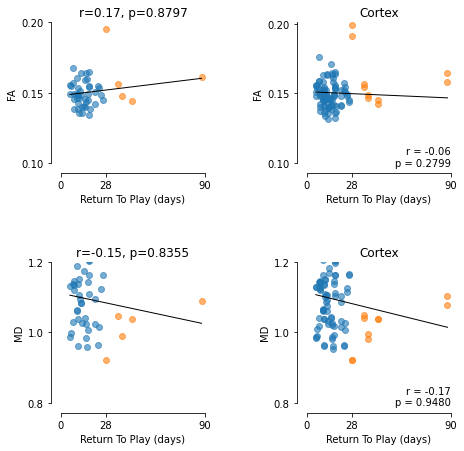

In [30]:
# plot FA and MD
import seaborn as sns
!pip install statannot
from statannot import add_stat_annotation
plt.rcParams['svg.fonttype'] = 'none'

metrics = ['FA','MD']
N = len(sub_list)
rtp_days_twice = np.hstack((rtp_days, rtp_days))

fig=plt.figure(figsize=(7,7))

#cortical regions   
for m, metric in enumerate(metrics):
    ctx_means_tmp = []
    ax=plt.subplot(len(metrics),2,2*m+1)
    for s, sub in enumerate(sub_list):
        if rtp.loc[int(sub), 'rtpLabel'] == 0:
            plt.scatter(rtp.loc[int(sub),"TIME_TORTP_DAYS"],np.mean(ctx_means[s,:,m]), color='#1f77b4', alpha=0.6)
            ctx_means_tmp.append(np.mean(ctx_means[s,:,m]))
        elif rtp.loc[int(sub), 'rtpLabel'] == 1:
            if np.isnan(rtp.loc[int(sub),"TIME_TORTP_DAYS"]) == False:
                plt.scatter(rtp.loc[int(sub),"TIME_TORTP_DAYS"],np.mean(ctx_means[s,:,m]), color='#ff7f0e', alpha=0.6)
                ctx_means_tmp.append(np.mean(ctx_means[s,:,m]))
    if metric == 'FA':
        sl, inter, r_val, p_val, std_err = scipy.stats.linregress(rtp_days, ctx_means_tmp, alternative='less')
    elif metric == 'MD':
        sl, inter, r_val, p_val, std_err = scipy.stats.linregress(rtp_days, ctx_means_tmp, alternative='greater')
    print("r=%.02f, p=%.04f" %(r_val,p_val)) 
    plt.plot(np.sort(rtp_days), inter+sl*np.sort(rtp_days), c='k', linestyle='-', linewidth=1)
    plt.ylim([0.2,1])
    plt.ylabel('%s' %metric)
    plt.title("r=%.02f, p=%.04f" %(r_val,p_val))
    plt.xlabel('Return To Play (days)')
    fig.subplots_adjust(hspace=0.4)
    fig.subplots_adjust(wspace=0.4)
    
    #removing top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(("outward", 10))
    ax.spines['left'].set_position(("outward", 10))
    if metric == 'FA':
        plt.ylim([0.1,0.2])
        plt.yticks([0.1,0.15,0.2])
    elif metric == 'MD':
        plt.ylim([0.8,1.2])
        plt.yticks([0.8,1,1.2])
    plt.xlim([10,90])
    plt.xticks([0,28,90])
    
    #repeating with left and right parcels plotted separetly    
    ax=plt.subplot(len(metrics),2,2*m+2)
    ctx_means_tmp = []
    for s, sub in enumerate(sub_list):
        if rtp.loc[int(sub), 'rtpLabel'] == 0:
            plt.scatter(rtp.loc[int(sub),"TIME_TORTP_DAYS"],np.mean(ctx_means[s,0:74,m]), color='#1f77b4', alpha=0.6) #left
            plt.scatter(rtp.loc[int(sub),"TIME_TORTP_DAYS"],np.mean(ctx_means[s,73:-1,m]), color='#1f77b4', alpha=0.6) #right
            ctx_means_tmp.append(np.mean(ctx_means[s,0:74,m])) #left
            ctx_means_tmp.append(np.mean(ctx_means[s,73:-1,m])) #right
        elif rtp.loc[int(sub), 'rtpLabel'] == 1:
            if np.isnan(rtp.loc[int(sub),"TIME_TORTP_DAYS"]) == False:
                plt.scatter(rtp.loc[int(sub),"TIME_TORTP_DAYS"],np.mean(ctx_means[s,0:74,m]), color='#ff7f0e', alpha=0.6) #left
                plt.scatter(rtp.loc[int(sub),"TIME_TORTP_DAYS"],np.mean(ctx_means[s,73:-1,m]), color='#ff7f0e', alpha=0.6) #right
                ctx_means_tmp.append(np.mean(ctx_means[s,0:74,m])) #left
                ctx_means_tmp.append(np.mean(ctx_means[s,73:-1,m])) #right
    if metric == 'FA':
        sl, inter, r_val, p_val, std_err = scipy.stats.linregress(rtp_days_twice, ctx_means_tmp, alternative='less')
    elif metric == 'MD':
        sl, inter, r_val, p_val, std_err = scipy.stats.linregress(rtp_days_twice, ctx_means_tmp, alternative='greater')
    print("r=%.02f, p=%.04f" %(r_val,p_val)) 
    plt.plot(np.sort(rtp_days_twice), inter+sl*np.sort(rtp_days_twice), c='k', linestyle='-', linewidth=1)
    plt.ylim([0.2,1])
    plt.ylabel('%s' %metric)
    plt.title("Cortex")
    plt.xlabel('Return To Play (days)')

    #removing top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(("outward", 10))
    ax.spines['left'].set_position(("outward", 10))
    if metric == 'FA':
        plt.ylim([0.1,0.201])
        plt.yticks([0.1,0.15,0.2])
    elif metric == 'MD':
        plt.ylim([0.8,1.2])
        plt.yticks([0.8,1,1.2])
    plt.xlim([10,90])
    plt.xticks([0,28,90])
    
    #add text
    ax.text(1, 0.12, "r = %.2f\np = %.4f" %(r_val,p_val), ha="right", va="top", transform=ax.transAxes, fontsize=10)

fig.subplots_adjust(wspace=0.7)
fig.subplots_adjust(hspace=0.7)
plt.savefig('boxplot_fa_md_orange_poster_ctx.svg', bbox_inches = "tight")
plt.show()

r=-0.06, p=0.2799
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

early v.s. late: t-test independent samples with Bonferroni correction, P_val=2.235e-04 stat=-3.830e+00
r=-0.17, p=0.9480
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

early v.s. late: t-test independent samples with Bonferroni correction, P_val=2.683e-04 stat=3.779e+00


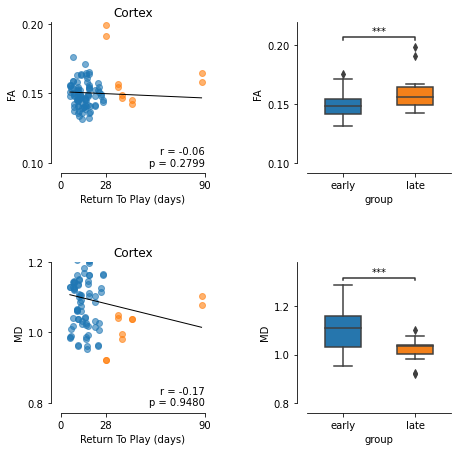

In [31]:
# plot FA and MD
import seaborn as sns
!pip install statannot
from statannot import add_stat_annotation
plt.rcParams['svg.fonttype'] = 'none'

metrics = ['FA','MD']
N = len(sub_list)
rtp_days_twice = np.hstack((rtp_days, rtp_days))
group_twice = np.hstack((groups, groups))

fig=plt.figure(figsize=(7,7))

#left+right
for m, metric in enumerate(metrics):
    ctx_means_tmp = []
    ax=plt.subplot(len(metrics),2,2*m+1)
    for s, sub in enumerate(sub_list):
        if rtp.loc[int(sub), 'rtpLabel'] == 0:
            plt.scatter(rtp.loc[int(sub),"TIME_TORTP_DAYS"],np.mean(ctx_means[s,0:74,m]), color='#1f77b4', alpha=0.6) #left
            plt.scatter(rtp.loc[int(sub),"TIME_TORTP_DAYS"],np.mean(ctx_means[s,73:-1,m]), color='#1f77b4', alpha=0.6) #right
            ctx_means_tmp.append(np.mean(ctx_means[s,0:74,m])) #left
            ctx_means_tmp.append(np.mean(ctx_means[s,73:-1,m])) #right
        elif rtp.loc[int(sub), 'rtpLabel'] == 1:
            if np.isnan(rtp.loc[int(sub),"TIME_TORTP_DAYS"]) == False:
                plt.scatter(rtp.loc[int(sub),"TIME_TORTP_DAYS"],np.mean(ctx_means[s,0:74,m]), color='#ff7f0e', alpha=0.6) #left
                plt.scatter(rtp.loc[int(sub),"TIME_TORTP_DAYS"],np.mean(ctx_means[s,73:-1,m]), color='#ff7f0e', alpha=0.6) #right
                ctx_means_tmp.append(np.mean(ctx_means[s,0:74,m])) #left
                ctx_means_tmp.append(np.mean(ctx_means[s,73:-1,m])) #right
    if metric == 'FA':
        sl, inter, r_val, p_val, std_err = scipy.stats.linregress(rtp_days_twice, ctx_means_tmp, alternative='less')
    elif metric == 'MD':
        sl, inter, r_val, p_val, std_err = scipy.stats.linregress(rtp_days_twice, ctx_means_tmp, alternative='greater')
    print("r=%.02f, p=%.04f" %(r_val,p_val)) 
    plt.plot(np.sort(rtp_days_twice), inter+sl*np.sort(rtp_days_twice), c='k', linestyle='-', linewidth=1)
    plt.ylim([0.2,1])
    plt.ylabel('%s' %metric)
    plt.title("Cortex")
    plt.xlabel('Return To Play (days)')

    #removing top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(("outward", 10))
    ax.spines['left'].set_position(("outward", 10))
    if metric == 'FA':
        plt.ylim([0.1,0.201])
        plt.yticks([0.1,0.15,0.2])
    elif metric == 'MD':
        plt.ylim([0.8,1.2])
        plt.yticks([0.8,1,1.2])
    plt.xlim([10,90])
    plt.xticks([0,28,90])
    
    #add text
    ax.text(1, 0.12, "r = %.2f\np = %.4f" %(r_val,p_val), ha="right", va="top", transform=ax.transAxes, fontsize=10)
    
    plt.subplot(len(metrics),2,2*m+2)
    if metric == 'FA':
        data = {'FA': means_fa, 'group': group_twice}
        plt.ylim([0.1,0.2])
        plt.yticks([0.1,0.15,0.2])
    elif metric == 'MD':
        data = {'MD': means_md, 'group': group_twice}
        plt.ylim([0.8,1.2])
        plt.yticks([0.8,1,1.2])
    df = pd.DataFrame(data)
    ax = sns.boxplot(data=df, x='group', y=metric, palette=['#1f77b4','#ff7f0e'], width=0.5, saturation=0.9)
    add_stat_annotation(ax, data=df, x='group', y=metric, test='t-test_ind',
                    box_pairs=[("early", "late")], text_format='star', loc='inside', verbose=2)
    plt.setp(ax.collections, alpha=0.8)
    
    #removing top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(("outward", 10))
    ax.spines['left'].set_position(("outward", 10))
    
fig.subplots_adjust(wspace=0.7)
fig.subplots_adjust(hspace=0.7)
plt.savefig('boxplot_fa_md_orange_poster_ctx.svg', bbox_inches = "tight")
plt.show()